CMPE 258 Final Project Python 2.7 Version
1. Author: Tu Lan 011495497 tu.lan@sjsu.edu
2. Date: 05/06/2018
3. Tips: Before running the code, please change the Directories to yours, especially the directory of datasets

In [2]:
# basic libraries
import os               # a system library, not related to algorithm          
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import time


# state control
state = 1
np.random.seed(state)

# To plot pretty figures
import seaborn as sns  # just a plot library. Not related to algorithms
%matplotlib inline
plt.style.use('seaborn')
sns.set(style="ticks", color_codes=True)

# Directories
PROJECT_ROOT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/'
DATA_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/data/'
MODEL_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/model/'
LOG_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/log/'
WEIGHT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/weight/'
RESULT_PATH = '/media/tulan/Linux/Pycharm/EM Cell Tracking/result/'

In [3]:
X_train = np.load(DATA_PATH + 'X_train_aug.npy')
y_train = np.load(DATA_PATH + 'y_train_aug.npy')
X_test = np.load(DATA_PATH + 'X_test.npy')
X_train.shape, y_train.shape, X_test.shape

((210, 512, 512, 1), (210, 512, 512, 1), (30, 512, 512, 1))

In [4]:
def split_train_val(X, y, ratio_train, state):
    # shuffle the sequence
    np.random.seed(state)
    num = len(y)
    shuffle_index = np.random.permutation(num)
    train_index = shuffle_index[:int(num * ratio_train)]
    val_index = shuffle_index[int(num * ratio_train):]
    X_train, y_train = X[train_index], y[train_index]
    X_val, y_val = X[val_index], y[val_index]
    return X_train, X_val, y_train, y_val


X_train, X_val, y_train, y_val = split_train_val(X_train, y_train, 0.9, state)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((189, 512, 512, 1), (21, 512, 512, 1), (189, 512, 512, 1), (21, 512, 512, 1))

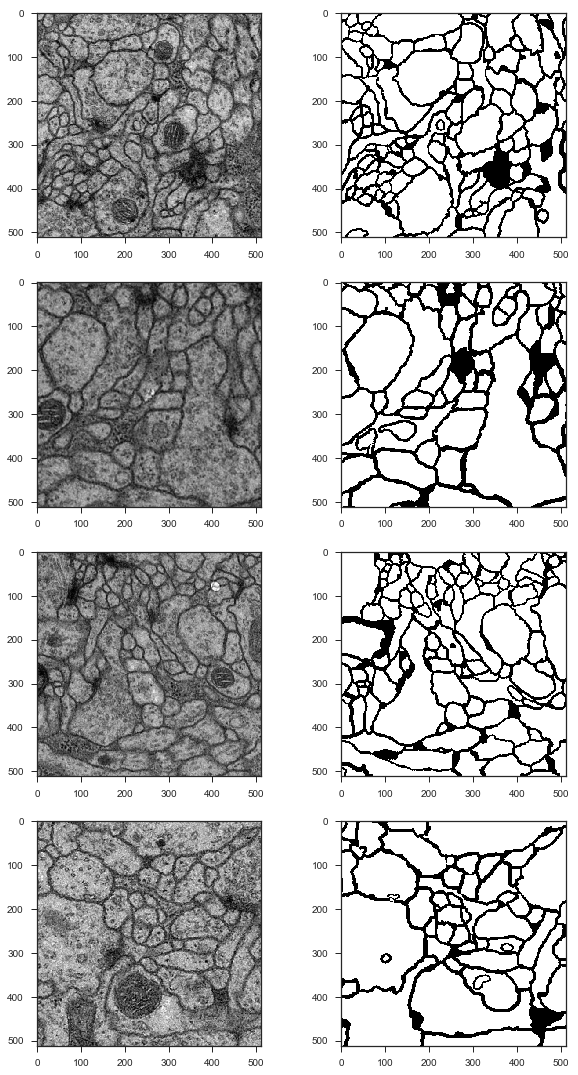

In [5]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 19))
for row in range(4):
    ax[row, 0].imshow(X_train[row].reshape(512, 512), cmap='gray')
    ax[row, 1].imshow(y_train[row].reshape(512, 512), cmap='binary')
    
plt.show()

In [7]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import load_model

from Loss_Functions import cross_entropy_balanced
from U_Net import u_net_fuse_v2
from Loss_Functions import dice_coef, dice_coef_loss, jaccard_coef, pixel_error

In [8]:
model_unet_side_fuse = u_net_fuse_v2(input_shape=(512, 512, 1))
model_unet_side_fuse.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 256, 256, 8)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [10]:
lr_decay = ReduceLROnPlateau(monitor='val_ofuse_pixel_error', factor=0.8, patience=5, verbose=1, 
                             min_lr=1e-4)
checkpointer = ModelCheckpoint(MODEL_PATH + 'checkpoint.h5', verbose=1, save_best_only=True)
tensorbord = TensorBoard(log_dir=LOG_PATH + 'UNET_Fuse_v2', write_graph=True)
callback_list = [lr_decay, checkpointer, tensorbord]

# optimizer = SGD(lr=1e-3, momentum=0.9, nesterov=False)
optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999)

model_unet_side_fuse.compile(loss={'o1': cross_entropy_balanced,
                                'o2': cross_entropy_balanced,
                                'o3': cross_entropy_balanced,
                                'o4': cross_entropy_balanced,
                                'o5': cross_entropy_balanced,
                                'ofuse': cross_entropy_balanced,
                                },
                          metrics={'ofuse': [dice_coef, jaccard_coef, pixel_error]},
                          optimizer=optimizer)

results = model_unet_side_fuse.fit(X_train, [y_train, y_train, y_train, y_train, y_train, y_train], 
                              validation_data=(X_val, [y_val, y_val, y_val, y_val, y_val, y_val]), 
                              batch_size=5, epochs=100, callbacks=callback_list, verbose=2)

Train on 189 samples, validate on 21 samples


Epoch 1/100


 - 9s - loss: 0.4586 - o1_loss: 0.1738 - o2_loss: 0.1083 - o3_loss: 0.0543 - o4_loss: 0.0416 - o5_loss: 0.0402 - ofuse_loss: 0.0403 - ofuse_dice_coef: 0.8604 - ofuse_jaccard_coef: 0.7543 - ofuse_pixel_error: 0.0553 - val_loss: 0.5995 - val_o1_loss: 0.1673 - val_o2_loss: 0.1150 - val_o3_loss: 0.0820 - val_o4_loss: 0.0772 - val_o5_loss: 0.0795 - val_ofuse_loss: 0.0784 - val_ofuse_dice_coef: 0.8199 - val_ofuse_jaccard_coef: 0.6923 - val_ofuse_pixel_error: 0.0758



Epoch 00001: val_loss improved from inf to 0.59952, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 2/100


 - 8s - loss: 0.4541 - o1_loss: 0.1738 - o2_loss: 0.1079 - o3_loss: 0.0535 - o4_loss: 0.0405 - o5_loss: 0.0392 - ofuse_loss: 0.0392 - ofuse_dice_coef: 0.8630 - ofuse_jaccard_coef: 0.7579 - ofuse_pixel_error: 0.0537 - val_loss: 0.6201 - val_o1_loss: 0.1682 - val_o2_loss: 0.1169 - val_o3_loss: 0.0856 - val_o4_loss: 0.0812 - val_o5_loss: 0.0847 - val_ofuse_loss: 0.0837 - val_ofuse_dice_coef: 0.8199 - val_ofuse_jaccard_coef: 0.6924 - val_ofuse_pixel_error: 0.0755



Epoch 00002: val_loss did not improve
Epoch 3/100


 - 8s - loss: 0.4543 - o1_loss: 0.1738 - o2_loss: 0.1079 - o3_loss: 0.0535 - o4_loss: 0.0405 - o5_loss: 0.0392 - ofuse_loss: 0.0393 - ofuse_dice_coef: 0.8632 - ofuse_jaccard_coef: 0.7583 - ofuse_pixel_error: 0.0538 - val_loss: 0.5938 - val_o1_loss: 0.1673 - val_o2_loss: 0.1149 - val_o3_loss: 0.0802 - val_o4_loss: 0.0762 - val_o5_loss: 0.0780 - val_ofuse_loss: 0.0772 - val_ofuse_dice_coef: 0.8142 - val_ofuse_jaccard_coef: 0.6841 - val_ofuse_pixel_error: 0.0800



Epoch 00003: val_loss improved from 0.59952 to 0.59377, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5
Epoch 4/100


 - 8s - loss: 0.4540 - o1_loss: 0.1739 - o2_loss: 0.1079 - o3_loss: 0.0534 - o4_loss: 0.0404 - o5_loss: 0.0391 - ofuse_loss: 0.0392 - ofuse_dice_coef: 0.8631 - ofuse_jaccard_coef: 0.7581 - ofuse_pixel_error: 0.0539 - val_loss: 0.6035 - val_o1_loss: 0.1675 - val_o2_loss: 0.1161 - val_o3_loss: 0.0829 - val_o4_loss: 0.0777 - val_o5_loss: 0.0799 - val_ofuse_loss: 0.0793 - val_ofuse_dice_coef: 0.8193 - val_ofuse_jaccard_coef: 0.6915 - val_ofuse_pixel_error: 0.0775



Epoch 00004: val_loss did not improve
Epoch 5/100


 - 8s - loss: 0.4534 - o1_loss: 0.1738 - o2_loss: 0.1078 - o3_loss: 0.0533 - o4_loss: 0.0404 - o5_loss: 0.0391 - ofuse_loss: 0.0391 - ofuse_dice_coef: 0.8635 - ofuse_jaccard_coef: 0.7587 - ofuse_pixel_error: 0.0536 - val_loss: 0.6082 - val_o1_loss: 0.1679 - val_o2_loss: 0.1160 - val_o3_loss: 0.0834 - val_o4_loss: 0.0789 - val_o5_loss: 0.0812 - val_ofuse_loss: 0.0808 - val_ofuse_dice_coef: 0.8217 - val_ofuse_jaccard_coef: 0.6951 - val_ofuse_pixel_error: 0.0742



Epoch 00005: val_loss did not improve
Epoch 6/100


 - 8s - loss: 0.4531 - o1_loss: 0.1737 - o2_loss: 0.1078 - o3_loss: 0.0533 - o4_loss: 0.0403 - o5_loss: 0.0390 - ofuse_loss: 0.0390 - ofuse_dice_coef: 0.8636 - ofuse_jaccard_coef: 0.7590 - ofuse_pixel_error: 0.0536 - val_loss: 0.5943 - val_o1_loss: 0.1671 - val_o2_loss: 0.1140 - val_o3_loss: 0.0809 - val_o4_loss: 0.0762 - val_o5_loss: 0.0781 - val_ofuse_loss: 0.0780 - val_ofuse_dice_coef: 0.8225 - val_ofuse_jaccard_coef: 0.6961 - val_ofuse_pixel_error: 0.0757



Epoch 00006: val_loss did not improve
Epoch 7/100


 - 8s - loss: 0.4479 - o1_loss: 0.1734 - o2_loss: 0.1073 - o3_loss: 0.0524 - o4_loss: 0.0392 - o5_loss: 0.0378 - ofuse_loss: 0.0379 - ofuse_dice_coef: 0.8676 - ofuse_jaccard_coef: 0.7651 - ofuse_pixel_error: 0.0520 - val_loss: 0.6201 - val_o1_loss: 0.1672 - val_o2_loss: 0.1145 - val_o3_loss: 0.0859 - val_o4_loss: 0.0824 - val_o5_loss: 0.0851 - val_ofuse_loss: 0.0849 - val_ofuse_dice_coef: 0.8251 - val_ofuse_jaccard_coef: 0.6997 - val_ofuse_pixel_error: 0.0712



Epoch 00007: val_loss did not improve
Epoch 8/100


 - 8s - loss: 0.4479 - o1_loss: 0.1733 - o2_loss: 0.1072 - o3_loss: 0.0523 - o4_loss: 0.0393 - o5_loss: 0.0379 - ofuse_loss: 0.0379 - ofuse_dice_coef: 0.8675 - ofuse_jaccard_coef: 0.7649 - ofuse_pixel_error: 0.0519 - val_loss: 0.5840 - val_o1_loss: 0.1669 - val_o2_loss: 0.1129 - val_o3_loss: 0.0786 - val_o4_loss: 0.0745 - val_o5_loss: 0.0756 - val_ofuse_loss: 0.0754 - val_ofuse_dice_coef: 0.8202 - val_ofuse_jaccard_coef: 0.6926 - val_ofuse_pixel_error: 0.0763



Epoch 00008: val_loss improved from 0.59377 to 0.58397, saving model to /media/tulan/Linux/Pycharm/EM Cell Tracking/model/checkpoint.h5


Epoch 9/100


 - 8s - loss: 0.4486 - o1_loss: 0.1733 - o2_loss: 0.1073 - o3_loss: 0.0525 - o4_loss: 0.0394 - o5_loss: 0.0381 - ofuse_loss: 0.0381 - ofuse_dice_coef: 0.8666 - ofuse_jaccard_coef: 0.7638 - ofuse_pixel_error: 0.0524 - val_loss: 0.6013 - val_o1_loss: 0.1677 - val_o2_loss: 0.1158 - val_o3_loss: 0.0828 - val_o4_loss: 0.0772 - val_o5_loss: 0.0790 - val_ofuse_loss: 0.0788 - val_ofuse_dice_coef: 0.8190 - val_ofuse_jaccard_coef: 0.6911 - val_ofuse_pixel_error: 0.0763



Epoch 00009: val_loss did not improve
Epoch 10/100


 - 8s - loss: 0.4477 - o1_loss: 0.1733 - o2_loss: 0.1072 - o3_loss: 0.0523 - o4_loss: 0.0392 - o5_loss: 0.0379 - ofuse_loss: 0.0379 - ofuse_dice_coef: 0.8666 - ofuse_jaccard_coef: 0.7636 - ofuse_pixel_error: 0.0521 - val_loss: 0.6367 - val_o1_loss: 0.1672 - val_o2_loss: 0.1179 - val_o3_loss: 0.0898 - val_o4_loss: 0.0854 - val_o5_loss: 0.0881 - val_ofuse_loss: 0.0883 - val_ofuse_dice_coef: 0.8260 - val_ofuse_jaccard_coef: 0.7011 - val_ofuse_pixel_error: 0.0701



Epoch 00010: val_loss did not improve
Epoch 11/100


 - 8s - loss: 0.4457 - o1_loss: 0.1732 - o2_loss: 0.1071 - o3_loss: 0.0520 - o4_loss: 0.0387 - o5_loss: 0.0374 - ofuse_loss: 0.0374 - ofuse_dice_coef: 0.8691 - ofuse_jaccard_coef: 0.7676 - ofuse_pixel_error: 0.0513 - val_loss: 0.6084 - val_o1_loss: 0.1674 - val_o2_loss: 0.1169 - val_o3_loss: 0.0827 - val_o4_loss: 0.0789 - val_o5_loss: 0.0813 - val_ofuse_loss: 0.0812 - val_ofuse_dice_coef: 0.8265 - val_ofuse_jaccard_coef: 0.7019 - val_ofuse_pixel_error: 0.0717



Epoch 00011: val_loss did not improve
Epoch 12/100


 - 8s - loss: 0.4426 - o1_loss: 0.1730 - o2_loss: 0.1068 - o3_loss: 0.0514 - o4_loss: 0.0380 - o5_loss: 0.0367 - ofuse_loss: 0.0367 - ofuse_dice_coef: 0.8716 - ofuse_jaccard_coef: 0.7715 - ofuse_pixel_error: 0.0501 - val_loss: 0.5987 - val_o1_loss: 0.1668 - val_o2_loss: 0.1142 - val_o3_loss: 0.0814 - val_o4_loss: 0.0773 - val_o5_loss: 0.0798 - val_ofuse_loss: 0.0792 - val_ofuse_dice_coef: 0.8123 - val_ofuse_jaccard_coef: 0.6817 - val_ofuse_pixel_error: 0.0850



Epoch 00012: val_loss did not improve
Epoch 13/100


 - 8s - loss: 0.4429 - o1_loss: 0.1730 - o2_loss: 0.1069 - o3_loss: 0.0514 - o4_loss: 0.0381 - o5_loss: 0.0368 - ofuse_loss: 0.0367 - ofuse_dice_coef: 0.8711 - ofuse_jaccard_coef: 0.7705 - ofuse_pixel_error: 0.0505 - val_loss: 0.5897 - val_o1_loss: 0.1667 - val_o2_loss: 0.1134 - val_o3_loss: 0.0806 - val_o4_loss: 0.0750 - val_o5_loss: 0.0772 - val_ofuse_loss: 0.0767 - val_ofuse_dice_coef: 0.8221 - val_ofuse_jaccard_coef: 0.6957 - val_ofuse_pixel_error: 0.0773



Epoch 00013: val_loss did not improve
Epoch 14/100


 - 8s - loss: 0.4435 - o1_loss: 0.1731 - o2_loss: 0.1069 - o3_loss: 0.0516 - o4_loss: 0.0382 - o5_loss: 0.0368 - ofuse_loss: 0.0368 - ofuse_dice_coef: 0.8706 - ofuse_jaccard_coef: 0.7699 - ofuse_pixel_error: 0.0507 - val_loss: 0.6002 - val_o1_loss: 0.1670 - val_o2_loss: 0.1155 - val_o3_loss: 0.0822 - val_o4_loss: 0.0772 - val_o5_loss: 0.0793 - val_ofuse_loss: 0.0789 - val_ofuse_dice_coef: 0.8226 - val_ofuse_jaccard_coef: 0.6962 - val_ofuse_pixel_error: 0.0767



Epoch 00014: val_loss did not improve
Epoch 15/100


 - 8s - loss: 0.4412 - o1_loss: 0.1730 - o2_loss: 0.1067 - o3_loss: 0.0511 - o4_loss: 0.0377 - o5_loss: 0.0363 - ofuse_loss: 0.0363 - ofuse_dice_coef: 0.8724 - ofuse_jaccard_coef: 0.7727 - ofuse_pixel_error: 0.0499 - val_loss: 0.5957 - val_o1_loss: 0.1667 - val_o2_loss: 0.1142 - val_o3_loss: 0.0818 - val_o4_loss: 0.0768 - val_o5_loss: 0.0783 - val_ofuse_loss: 0.0780 - val_ofuse_dice_coef: 0.8201 - val_ofuse_jaccard_coef: 0.6924 - val_ofuse_pixel_error: 0.0793



Epoch 00015: val_loss did not improve
Epoch 16/100


 - 8s - loss: 0.4412 - o1_loss: 0.1730 - o2_loss: 0.1066 - o3_loss: 0.0511 - o4_loss: 0.0377 - o5_loss: 0.0364 - ofuse_loss: 0.0364 - ofuse_dice_coef: 0.8718 - ofuse_jaccard_coef: 0.7719 - ofuse_pixel_error: 0.0501 - val_loss: 0.6175 - val_o1_loss: 0.1673 - val_o2_loss: 0.1151 - val_o3_loss: 0.0846 - val_o4_loss: 0.0828 - val_o5_loss: 0.0838 - val_ofuse_loss: 0.0838 - val_ofuse_dice_coef: 0.8263 - val_ofuse_jaccard_coef: 0.7016 - val_ofuse_pixel_error: 0.0704



Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.000800000037998.

Epoch 00016: val_loss did not improve
Epoch 17/100


KeyboardInterrupt: 

In [11]:
model_unet_side_fuse.save_weights(WEIGHT_PATH + 'UNET_fuse_v2_weight.h5')
model_unet_side_fuse.save(MODEL_PATH + 'UNET_fuse_v2_model.h5')
model_json = model_unet_side_fuse.to_json()
with open(MODEL_PATH + 'UNET_fuse_v2_model.json', "w") as json_file:
    json_file.write(model_json)

In [12]:
model_unet_side_fuse = u_net_fuse_v2(input_shape=(512, 512, 1))
model_unet_side_fuse.load_weights(WEIGHT_PATH + 'UNET_fuse_v2_weight.h5')

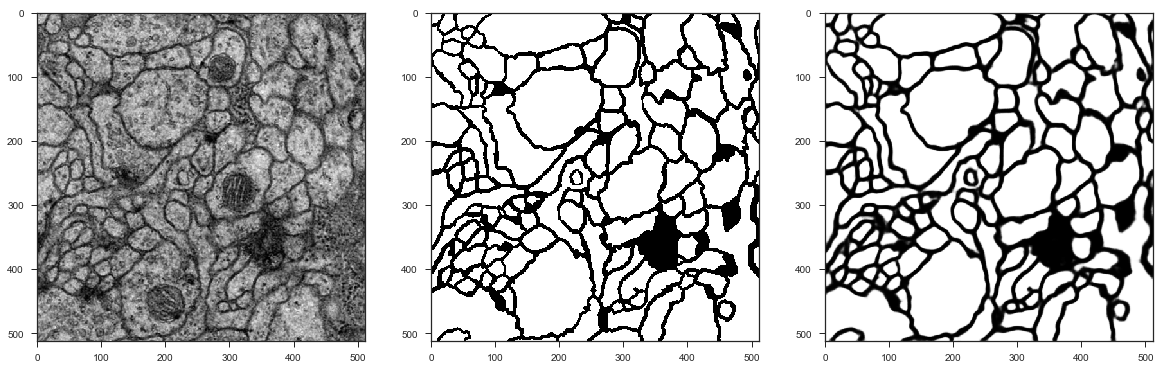

In [13]:
y_pred = model_unet_side_fuse.predict(X_train[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,16))
plt.subplot(1,3,1)
plt.imshow(X_train[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_train[0].reshape((512, 512)), cmap='binary')
plt.subplot(1,3,3)
plt.imshow(y_pred, cmap='binary')

plt.show()

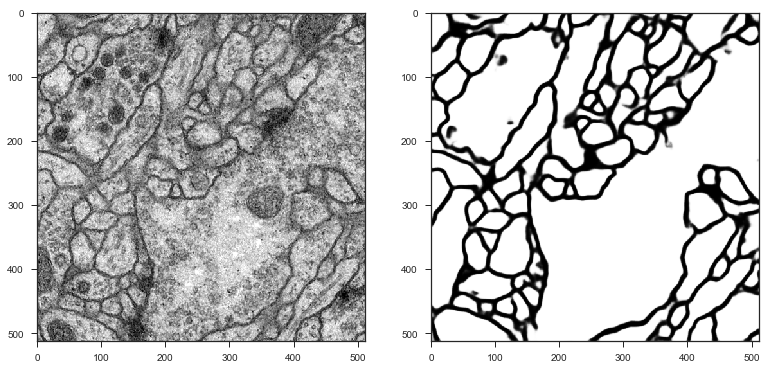

In [14]:
y_pred = model_unet_side_fuse.predict(X_test[0].reshape((-1, 512, 512, 1)))[-1]
y_pred = y_pred.reshape((512, 512))
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test[0].reshape((512, 512)), cmap='gray')
plt.subplot(1,3,2)
plt.imshow(y_pred, cmap='binary')
plt.show()

In [17]:
result = model_unet_side_fuse.predict(X_test)[-1]
result = result.astype(np.float32)
result.shape

(30, 512, 512, 1)

In [18]:
timestamp = time.strftime("%Y%m%d-%H%M%S")
tiff.imsave(RESULT_PATH + 'Unet_fuse_v2_' + timestamp + '.tif', result, dtype=np.float32)

In [20]:
test_result = tiff.imread(RESULT_PATH + 'Unet_fuse_v2_' + timestamp + '.tif')
test_result.shape, test_result[0].shape, type(test_result[0,0,0,0])

((30, 512, 512, 1), (512, 512, 1), numpy.float32)

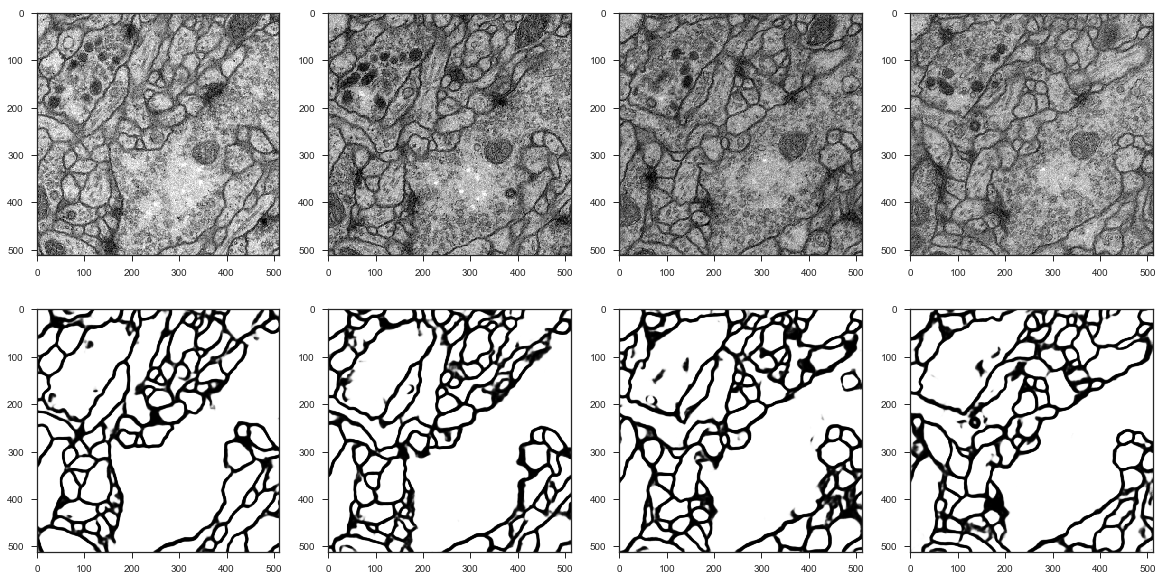

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
for row in range(2):
    for col in range(4):
        if row == 0:         
            ax[row, col].imshow(X_test[col].reshape(512, 512), cmap='gray')
        else:
            ax[row, col].imshow(test_result[col].reshape(512, 512), cmap='binary')

plt.show()